In [8]:
# Importing necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import openpyxl

In [9]:
# Directory setup
gp2_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
output_analysis_dir = os.path.join(gp2_dir, 'Distribution Analysis', 'Output Analysis')
assert output_analysis_dir == os.getcwd(), f"Expected output_analysis_dir to be the current working directory."
figures_dir = os.path.join(gp2_dir, 'Report', 'Figures', 'Distribution Analysis', 'Initial Output Analysis')
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
laptop_timings_xlsx = os.path.join(output_analysis_dir, '300_weeks', 'laptop_timings.xlsx')
assert os.path.exists(laptop_timings_xlsx), f"Expected {laptop_timings_xlsx} to exist."

# Analysis of Laptop Timings from initial simulation

In [10]:
laptop_timings = pd.read_excel(laptop_timings_xlsx)
laptop_timings.head()

/opt/homebrew/anaconda3/envs/Group_Project_2/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,order_num,laptop_num,arrival_time,completion_time,cycle_time,shipped_time
0,1,1,9.335681,62.988000,53.652319,NaN
1,1,2,9.335681,54.562965,45.227284,NaN
2,1,3,9.335681,84.741911,75.406230,91.224379
3,2,4,10.316637,65.913380,55.596743,NaN
4,2,5,10.316637,98.946773,88.630136,NaN


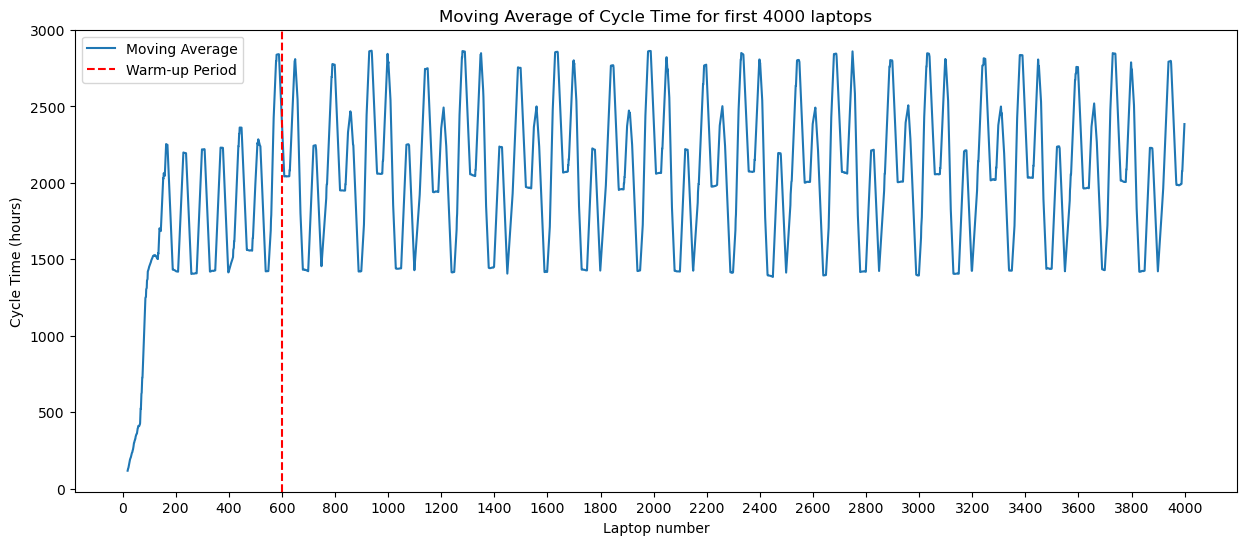

In [18]:
# plot the moving average of the cycle time
N = len(laptop_timings)
max_laptop_count = 4000
plot_tick_step = int(max_laptop_count / 20)
ticks = range(0, max_laptop_count + plot_tick_step, int(max_laptop_count / 20))
moving_average_window = 20
laptop_timings['moving_average'] = laptop_timings['cycle_time'].rolling(window=moving_average_window).mean()
plt.figure(figsize=(15, 6))
plt.plot(laptop_timings['moving_average'][:max_laptop_count], label='Moving Average')
plt.title(f'Moving Average of Cycle Time for first {max_laptop_count} laptops')
plt.xlabel('Laptop number')
plt.ylabel('Cycle Time (hours)')
plt.xticks(ticks=ticks, labels=ticks)
warm_up_period = 600
plt.axvline(x=warm_up_period, color='red', linestyle='--', label='Warm-up Period')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'moving_average_cycle_time.png'), dpi=300)
plt.show()

In [12]:
# Define the time window for the analysis as twice the warm-up period
time_window = 2 * warm_up_period

# Determine the number of time windows for the analysis
laptop_timings_split = []
for i in range(warm_up_period, N, time_window):
    laptop_timings_split.append(laptop_timings.iloc[i:i + time_window])

print(f"Number of available time windows: {len(laptop_timings_split)}")
laptop_timings_split[0].head()

Number of available time windows: 28


,order_num,laptop_num,arrival_time,completion_time,cycle_time,shipped_time,moving_average
600,1438,601,9101.100906,11140.284095,2039.183189,11158.478386,2403.415941
601,1444,602,9117.813643,11164.989150,2047.175507,NaN,2362.620568
602,1444,603,9117.813643,11154.900901,2037.087258,11170.333766,2321.928911
603,1445,604,9131.793543,11169.572812,2037.779269,NaN,2281.862743
604,1445,605,9131.793543,11177.433094,2045.639551,NaN,2241.563523


## Two-Stage Method

1. Run $m_0$ replications in order to obtain $Y^1, \ldots, Y^{m_0}$
2. Estimate 
    $$\bar{Y} = \frac{1}{m_0} \sum_{i=1}^{m_0} Y^i, \quad S^2_{m_0} = \frac{\sum_{i=1}^{m_0}(Y^i-\bar{Y})^2}{m_0-1}$$
3. Let $$m = \min\left\{n : n \ge \frac{t^2_{n-1, 1-\alpha/2} S^2_{m_0}}{\epsilon^2}\right\}$$ where $\epsilon$ is the desired precision, in our case $\epsilon \le \bar{X}/100$, where $\bar{X}$ is the true mean, and $t_{n-1, 1-\alpha/2}$ is the $(1-\alpha/2)$ quantile of the t-distribution with $n-1$ degrees of freedom.
4. Run $m$ "new" replications in order to obtain $X^1, \ldots, X^m$
5. Estimate 
    $$\bar{X} = \frac{1}{m} \sum_{i=1}^{m} X^i, \quad S^2_{m} = \frac{\sum_{i=1}^{m}(X^i-\bar{X})^2}{m-1}$$
6. Compute the confidence interval
    $$\left(\bar{X} - t_{m-1, 1-\alpha/2} \frac{S_m}{\sqrt{m}}, \bar{X} + t_{m-1, 1-\alpha/2} \frac{S_m}{\sqrt{m}}\right)$$

In [15]:
# Run the m_0 replications
m0 = 5

def get_cycle_time_mean(split):
    return split['cycle_time'].mean()

cycle_time_means = list(map(get_cycle_time_mean, laptop_timings_split))
Y_is = []
for i in range(m0):
    Y_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
Y_bar = sum(Y_is) / m0
s2_m0 = sum([(Y_i - Y_bar) ** 2 for Y_i in Y_is]) / (m0 - 1)
s_m0 = s2_m0 ** 0.5
print(f"Y_bar: {Y_bar:.2f} minutes, s_m0: {s_m0:.2f} minutes")

# Calculate sample eps
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2)
eps = z * s_m0 / m0
print(f"epsilon: {eps:.2f} minutes")

# Solve the inequality $$m = \min\left\{n : n \ge \frac{t^2_{n-1, 1-\alpha/2} S^2_{m_0}}{\epsilon^2}\right\}$$
# to find the number of replications needed to achieve the desired precision
def get_m(m0, s_m0, eps, alpha):
    n = m0
    while True:
        t = stats.t.ppf(1 - alpha / 2, n - 1)
        s2_n = s_m0 ** 2 * m0 / n
        if n >= (t ** 2 * s2_n) / (eps ** 2):
            break
        n += 1
    return n
m = get_m(m0, s_m0, 0.01*Y_bar, alpha)
print(f"Number of replications needed: {m}")

X_is = []
for i in range(m):
    X_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
X_bar = sum(X_is) / m
s2_m = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
s_m = s2_m ** 0.5
print(f"X_bar: {X_bar:.2f} minutes, s_m: {s_m:.2f} minutes")
t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
epsilon = t_alpha * s_m / m
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon

print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"The half width of the confidence interval is {epsilon:.2f} minutes")

Y_bar: 2102.00 minutes, s_m0: 11.99 minutes
epsilon: 4.70 minutes
Number of replications needed: 5
X_bar: 2095.90 minutes, s_m: 11.59 minutes
Confidence interval: [2089.47, 2102.34] minutes
The half width of the confidence interval is 6.44 minutes


## Sequential Procedure

- Two stage method does not "guarantee" the desired width! 
- The following sequential procedure does guarantee the desired width, 
1. Perform $m_0$ replications and get $X^1, \ldots, X^{m_0}$ and set $m = m_0$
2. Form 
    $$\bar{X} = \frac{1}{m} \sum_{i=1}^{m} X^i, \quad s^2 = \frac{\sum_{i=1}^{m}(X^i-\bar{X})^2}{m-1}$$
3. If 
    $$\frac{t_{m-1, 1-\alpha/2} s}{\sqrt{m}} < \epsilon$$
    then stop and output the confidence interval
    $$\left[\bar{X} - \epsilon, \bar{X} + \epsilon\right]$$
4. Otherwise generate one more replication $X^{m+1}$ and set $m = m + 1$ and go to step 2

In [14]:
cycle_time_means = list(map(get_cycle_time_mean, laptop_timings_split))

## Perform $m_0$ replications and get $X^1, \ldots, X^{m_0}$ and set $m = m_0$
desired_precision = 0.01 * Y_bar
m0 = 5
X_is = []
for i in range(m0):
    X_is.append(cycle_time_means.pop(0))

# 2. Form $$\bar{X} = \frac{1}{m} \sum_{i=1}^{m} X^i, \quad s^2 = \frac{\sum_{i=1}^{m}(X^i-\bar{X})^2}{m-1}$$
while True:
    m = m0
    X_bar = sum(X_is) / m
    s2 = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
    s = s2 ** 0.5
    t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
    epsilon = t_alpha * s / m
    if epsilon <= desired_precision:
        break
    m += 1
    X_is.append(cycle_time_means.pop(0))
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon
print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"Number of replications needed: {m}")

Confidence interval: [2095.34, 2108.65] minutes
Number of replications needed: 5
